In [1]:
%load_ext sql

In [2]:
%sql sqlite:///C:/sqlite/chinook2.db


# 1) Discovering Window Functions

Until now, we've been able to answer questions about aggregating data using the `GROUP BY` clause, but sometimes we'll encounter questions in our analysis that go beyond the capabilities of `GROUP BY`. Here are a few examples:

* What's the 7-day rolling average of daily sales?

* What's the year-to-date sales growth rate compared to the same period last year?

* What's the difference between each employee’s salary and their department’s average salary?

SQL has a solution for handling these complex questions: window functions. Throughout this course, we'll learn how to answer questions like these and see how powerful window functions can be.

**GROUP BY**

Adding the `GROUP BY` clause to a SQL query enables us to apply aggregate functions, such as `SUM`, `MIN`, `COUNT`, or `AVG`, to groups of rows. The `GROUP BY` clause collapses the individual rows with the same value for the columns in the GROUP BY clause into a single row that contains summary values. Let’s take a look at an example to understand the concept properly. Suppose we have a table containing the capital bike share’s trip data stored in a PostgreSQL database as follows:

| start_date                 | end_date                   | duration | start_station_num | start_station                  | end_station_num | end_station                      | bike_num | member_type |
|----------------------------|----------------------------|----------|----------------------|--------------------------------|--------------------|----------------------------------|-------------|-------------|
| 2017-10-01 01:00:00.000000 | 2017-10-01 01:04:00.000000 | 285      | 31400                | Georgia & New Hampshire Ave NW | 31404              | 9th & Upshur St NW               | W22821      | Member      |
| 2017-10-01 01:01:00.000000 | 2017-10-01 01:15:00.000000 | 816      | 31522                | 2nd St & Seaton Pl NE          | 31618              | 4th & East Capitol St NE         | W00940      | Member      |
| 2017-10-01 01:01:00.000000 | 2017-10-01 01:34:00.000000 | 2000     | 31044                | King St & Patrick St           | 31041              | Prince St & Union St             | W00201      | Casual      |
| 2017-10-01 01:02:00.000000 | 2017-10-01 01:15:00.000000 | 798      | 31288                | 4th St & Madison Dr NW         | 31266              | 11th & M St NW                   | W23360      | Member      |
| 2017-10-01 01:02:00.000000 | 2017-10-01 02:09:00.000000 | 3978     | 31258                | Lincoln Memorial               | 31233              | 17th & K St NW / Farragut Square | W22595      | Casual      |

Each row represents one trip. Most fields are self-explanatory, except `member_type`, which takes two values:

* `Member`, which indicates a monthly membership

* `Casual`, which indicates that the bike rider bought a 3-day pass.

Let’s obtain the average trip’s duration for each member type in seconds.

```sql
SELECT member_type, AVG(duration) AS avg_trip_duration
  FROM tbl_bikeshare
 GROUP BY member_type;

 ```

 | member_type | avg_trip_duration     |
|-------------|-----------------------|
| Casual      | 2223.7435897435897436 |
| Member      | 733.0706225680933852  |

As shown above, adding the `GROUP BY `clause to the query returns a summary row for each unique grouping, not the entire result set. The result set loses the detail columns except for those in the `GROUP BY` clause.

**Window Functions**

In contrast, queries with *window functions* perform aggregation without requiring a `GROUP BY` clause. Unlike queries with a `GROUP BY` clause, the individual rows are not collapsed. In other words, even though window functions enable us to apply aggregate functions like `AVG()`, `SUM()`, and `COUNT()` on a set of rows, individual rows are still accessible.

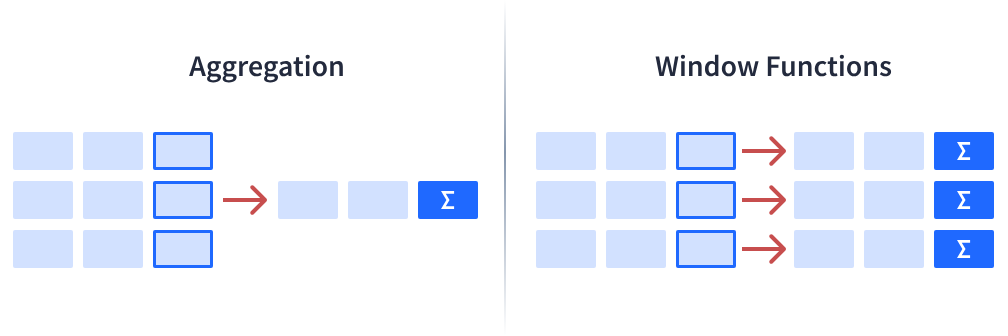

The true power of window functions is that they can return all the columns in the `SELECT` list along with the result of the expression with the window function as just another column.

```sql
SELECT bike_number, member_type, duration,
       AVG(duration) OVER(PARTITION BY member_type) AS avg_trip_duration
  FROM tbl_bikeshare;
```

We can see that the result includes the individual rows and the result of the window function (**in the fourth column**).

# 2) Types of Window Functions in SQL

In response to the growing demand for powerful data analysis tools in recent years, several new window functions have been introduced to SQL databases. This trend will likely continue as data analysis becomes more complex and sophisticated, and we expect to see the development of even more advanced window functions in the future. For now, we can categorize the existing window functions in SQL supported by PostgreSQL into four groups:

**Aggregate Functions**: We're all familiar with aggregate functions like SUM(), AVG(), and COUNT() in queries with GROUP BY clause. The aggregate function must operate on a set, whether a GROUP BY clause or a window specification defines the set. We'll discuss them in lesson 3.

**Ranking Functions:** Ranking and indexing data to figure out which rows are the best in the dataset can be done with ranking functions like `RANK()`, `DENSE_RANK()`, `ROW_NUMBER()`, and `NTILE()`.

**Distribution Functions:** This type of window function includes `CUME_DIST()` and `PERCENT_RANK()`, which provide information on the data distribution and are used in *statistical analysis*.

**Offset Functions:** There are two categories of window offset functions. The first category includes the `LAG()` and `LEAD()` functions, which return a value from a specific row before and after the current row. The second category includes the `FIRST_VALUE()`, `LAST_VALUE()`, and `NTH_VALUE()` functions, which respectively return a value from the first, last, and nth rows in the current window. We'll discuss these functions in lesson 6.

# 3) Window Function Syntax

As mentioned earlier, SQL window functions allow us to apply various calculations to a set of rows (also called a window) related to the current row and return a single value.

The `OVER` clause defines the specification of a window and involves three core elements:

* Partitioning definition

* Ordering definition

* Framing definition

However, depending on the function we call, some elements aren't required; even the `OVER` clause can be empty.

The basic syntax of the window function call as part of a `SELECT` statement is as follows:

```sql
function_name([expression]) OVER 
(
    [partition_definition]
    [order_definition]
    [frame_definition]
) [AS column_name]
```

Let's take a quick look at the elements of the window function syntax. SQL provides different types of window functions which need to appear before the `OVER()` clause. We'll learn the functions in detail in the following lessons. The `OVER()` clause determines which rows are included in a window before a window function computes a value for each row in the window. As shown in the syntax above, the OVER() clause supports the following arguments:

* The `PARTITION BY` expression divides the result set into partitions, or groups, based on one or more columns. The window function is then applied to each partition separately.

* The `ORDER BY` expression determines the order in which the window function is applied. Results can be ordered in ascending (ASC) or descending (DESC) order.

* The `frame_definition` defines a frame bounded by the `partition_definition` section, so a given window function will be applied to the rows in the frame. Framing is an advanced topic we'll cover in the next lesson.

# 4) The OVER() Clause

Let's look deeper at the OVER() clause on this screen.

Before diving into the details, let's explore the `employee` table, which represents the details of a company’s employees, by running the following query in the code runner.

```sql
SELECT * 
  FROM employee;
```

| employee_id | last_name | first_name | department | title               | hire_date  | salary    |
|-------------|-----------|------------|------------|---------------------|------------|-----------|
| 1           | Adams     | Andrew     | Management | General Manager     | 2002-08-13 | 108000.00 |
| 2           | Edwards   | Nancy      | Sales      | Sales Manager       | 2002-04-30 | 98900.00  |
| 3           | Peacock   | Jane       | Sales      | Sales Support Agent | 2002-03-31 | 87000.00  |
| 4           | Park      | Margaret   | Sales      | Sales Support Agent | 2003-05-02 | 69800.00  |
| 5           | Johnson   | Steve      | Sales      | Sales Support Agent | 2003-10-16 | 76500.00  |
| 6           | Mitchell  | Michael    | IT         | IT Manager          | 2003-10-16 | 89900.00  |
| 7           | King      | Robert     | IT         | IT Staff            | 2004-01-01 | 67800.00  |
| 8           | Callahan  | Laura      | IT         | IT Staff            | 2004-03-03 | 78000.00  |
| 9           | John      | Edward     | IT         | IT Staff            | 2004-09-18 | 75900.00  |

As we've seen, the data consists of the details of nine employees from different departments.

What if we want aggregated data, such as average salary, and non-aggregated data, such as employee details? There are different ways to implement this query. However, the most efficient approach is with window functions and the `OVER()` clause.

```sql
SELECT first_name, last_name, department, title, salary,
       AVG(salary) OVER() AS average_salary
  FROM employee;
  ```
| first_name | last_name | department | title               | salary    | average_salary     |
|------------|-----------|------------|---------------------|-----------|--------------------|
| Andrew     | Adams     | Management | General Manager     | 108000.00 | 83533.333333333333 |
| Nancy      | Edwards   | Sales      | Sales Manager       | 98900.00  | 83533.333333333333 |
| Jane       | Peacock   | Sales      | Sales Support Agent | 87000.00  | 83533.333333333333 |
| Margaret   | Park      | Sales      | Sales Support Agent | 69800.00  | 83533.333333333333 |
| Steve      | Johnson   | Sales      | Sales Support Agent | 76500.00  | 83533.333333333333 |
| Michael    | Mitchell  | IT         | IT Manager          | 89900.00  | 83533.333333333333 |
| Robert     | King      | IT         | IT Staff            | 67800.00  | 83533.333333333333 |
| Laura      | Callahan  | IT         | IT Staff            | 78000.00  | 83533.333333333333 |
| John       | Edward    | IT         | IT Staff            | 75900.00  | 83533.333333333333 |

By specifying a **blank** `OVER()` clause, we can define a window that covers the **whole data set**. Consequently, the calculation is done across all the rows. In this example, we get the **average salary across the entire table**.

## Instructions

Write a query that returns the following information for all employees in the employee table:

* first_name

* last_name

* salary

* the difference between each employee’s salary and the average salary of all employees, aliased as `difference`.

In [ ]:
%%sql
SELECT first_name, last_name, salary, salary-AVG(salary) OVER() as difference
FROM employee

# 5) Partitioning a Window

Partitioning a window divides the window into smaller windows based on one or more columns. The `PARTITION BY` expression limits the visible window to only rows with the same values as the current row. In other words, each window consists only of the rows matching the `PARTITION BY` column or columns.

Let's practice partitioning with an example.

Suppose we're interested in knowing the **average salary in each department**.

```sql
SELECT first_name, last_name, department, title, salary,
       AVG(salary) OVER(PARTITION BY department) AS average_salary
  FROM employee;
  ```

  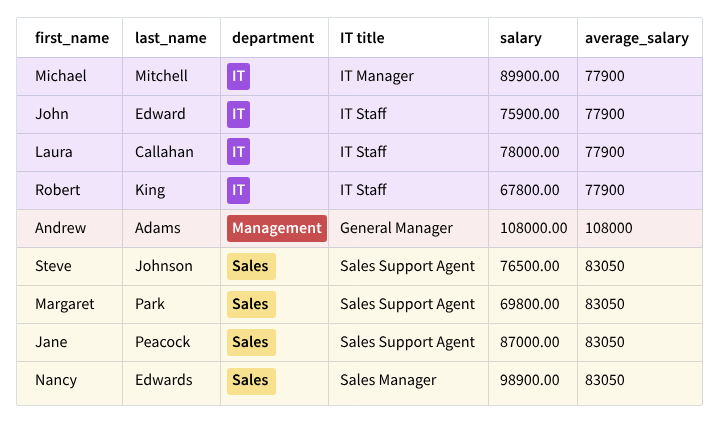

The query above:

* Uses `AVG()` to calculate the average salary

* Partitions the data by the `department` column

Because we partitioned the data by `department`, the salary values from one department were not retrieved by rows of another department.


## Instructions

We're interested in knowing the details of employees and how many employees work for the same department as the current employee.

Write a query that returns the following columns:

* `first_name`

* `last_name`

* `department`

* `title`

The number of employees working for the same department as the current employee. Alias this as `num_employees_department`.

In [ ]:
%%sql
SELECT first_name, last_name, department, title, 
       COUNT(first_name) OVER(PARTITION BY department) AS num_employees_department
  FROM employee;

# 6) Ordering a Window

The logical order of the rows within the complete result set or each partition of the result set can be defined with the `ORDER BY` clause. Simply put, the rows within each partition can be sorted based on the order specification.

The following example uses the `ORDER BY` clause to return the running total of the trip's duration for a specific bike.

```sql
SELECT start_date, bike_number, duration,
       SUM(duration) OVER (ORDER BY start_date) AS running_total
  FROM tbl_bikeshare 
 WHERE bike_number='W22661';
 ```

 The above snippet takes the sum of multiple trips' durations over the entire result set, which is ordered by the trips' start dates.

The `ORDER BY` clause serves completely different purposes in different types of window functions, which makes it one of the most confusing elements of the `OVER()` clause. However, there's no need to worry about these challenging concepts now; we'll cover them in the following lessons.

## Instructions

Consider the table `apple_sales_quantity_by_month`, which represents the sale quantities of Apple phones in each month:

| sales_date | brand | quantity |
|------------|-------|----------|
| 2022-01-31 | Apple | 50       |
| 2022-02-28 | Apple | 40       |
| 2022-03-31 | Apple | 25       |
| 2022-04-30 | Apple | 30       |
| 2022-05-31 | Apple | 47       |

1. Write a query that returns the `sales_date`, `brand`, `quantity`, and running total of monthly sales aliased as `running_total_quantity`.

In [ ]:
%%sql
SELECT sales_date, brand, quantity, SUM(quantity) OVER(ORDER BY sales_date) --soma acumulada mês a mês

FROM apple_sales_quantity_by_month